# Stock Market Forecasting Using Arima , Sarima


In this notebook, we analyze Google stock price data from June 27, 2024 to June 27, 2025.

We'll explore the data for trends, seasonality, and noise, and apply transformations if the series is non-stationary.

To forecast the next 30 days, we'll implement both ARIMA and SARIMA models and evaluate their performance using appropriate metrics.

---



In [140]:
# Importing necessary libraries
import pandas as pd, numpy as np , matplotlib.pyplot as plt, seaborn as sns , plotly.express as px
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf
import datetime as dt
from datetime import date , timedelta

In [141]:
# Define the time period to get data from
start = dt.datetime.today() - timedelta(365)
start_date = start.strftime("%Y-%m-%d")

end = dt.datetime.today()
end_date = end.strftime("%Y-%m-%d")
# start_date = "2024-06-27"
# end_date = "2025-06-27"
print(f"The data will be between {start_date} to {end_date} ")

The data will be between 2024-06-30 to 2025-06-30 


In [142]:
# Getting data from yfinance for a specific ticker
ticker = 'GOOGL'
df = yf.download(tickers=ticker, start=start_date, end=end_date, progress=False)
df.head()

Price,Close,High,Low,Open,Volume
Ticker,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL
Date,,,,,
2024-07-01,182.107864,182.993573,180.426009,182.147665,16006100
2024-07-02,184.347015,184.675426,180.684748,181.172391,17372500
2024-07-03,184.924210,185.192897,183.112976,183.958885,10242100
2024-07-05,189.681168,189.939909,184.904304,184.964013,20967500
2024-07-08,188.118729,189.253232,186.874755,188.984530,21035900


In [143]:
# Dropping the multi-level column index to simplify the DataFrame
df.columns = df.columns.droplevel(1)

In [144]:
# Displaying information about the dataframe, including data types and non-null values
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 249 entries, 2024-07-01 to 2025-06-27
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   249 non-null    float64
 1   High    249 non-null    float64
 2   Low     249 non-null    float64
 3   Open    249 non-null    float64
 4   Volume  249 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 11.7 KB


In [145]:
# Adding a 'Date' column from the index for easier manipulation
df["Date"] = df.index

In [146]:
# Selecting 'Date' and 'Close' columns and setting 'Date' as the new index
df = df[["Date","Close"]]
df.reset_index(drop=True, inplace=True)
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

In [147]:
# Displaying the first few rows after selecting columns and setting the index
df.head()

Price,Close
Date,
2024-07-01,182.107864
2024-07-02,184.347015
2024-07-03,184.924210
2024-07-05,189.681168
2024-07-08,188.118729


In [148]:
# Renaming the 'Close' column for clarity
df.columns = ["Close"]

In [149]:
# Displaying information about the dataframe after column renaming
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 249 entries, 2024-07-01 to 2025-06-27
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   249 non-null    float64
dtypes: float64(1)
memory usage: 3.9 KB


In [150]:
# Displaying the first few rows after column renaming
df.head()

,Close
Date,
2024-07-01,182.107864
2024-07-02,184.347015
2024-07-03,184.924210
2024-07-05,189.681168
2024-07-08,188.118729


In [151]:
# Displaying descriptive statistics of the dataframe, such as mean, std, min, max
df.describe()

,Close
count,249.000000
mean,171.371912
std,13.194162
min,144.525040
25%,162.359711
50%,168.266296
75%,180.147369
max,205.893341


In [152]:
# Plotting the closing price over time to visualize the trend
fig = px.line(df, x=df.index, y="Close", title=f'{ticker} Stock Price')
fig.show()

#Key Findings:

The trend appears non-linear and cyclical.

There are repeated peaks and troughs, suggesting potential seasonal components.

Volatility increases notably after February 2025, as seen in more frequent up-down movements.

The series is not strictly stationary , mean and variance seem to change over time.

A simple ARIMA model may not capture these dynamics well, reinforcing the need for SARIMA or seasonal decomposition.

In [153]:
# Checking for stationarity using the Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
def checking_stationarity(df):
    """
    Performs the Augmented Dickey-Fuller test to check for stationarity.

    Parameters:
    - df: pandas Series or DataFrame

    Prints the ADF statistic, p-value, and whether the series is stationary.
    """
    result = adfuller(df)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1] <= 0.05:
        print('The series is stationary')
    else:
        print('The series is non-stationary')


In [154]:
# Checking stationarity of the original dataframe using the defined function
checking_stationarity(df)

ADF Statistic: -1.877178
p-value: 0.342872
The series is non-stationary


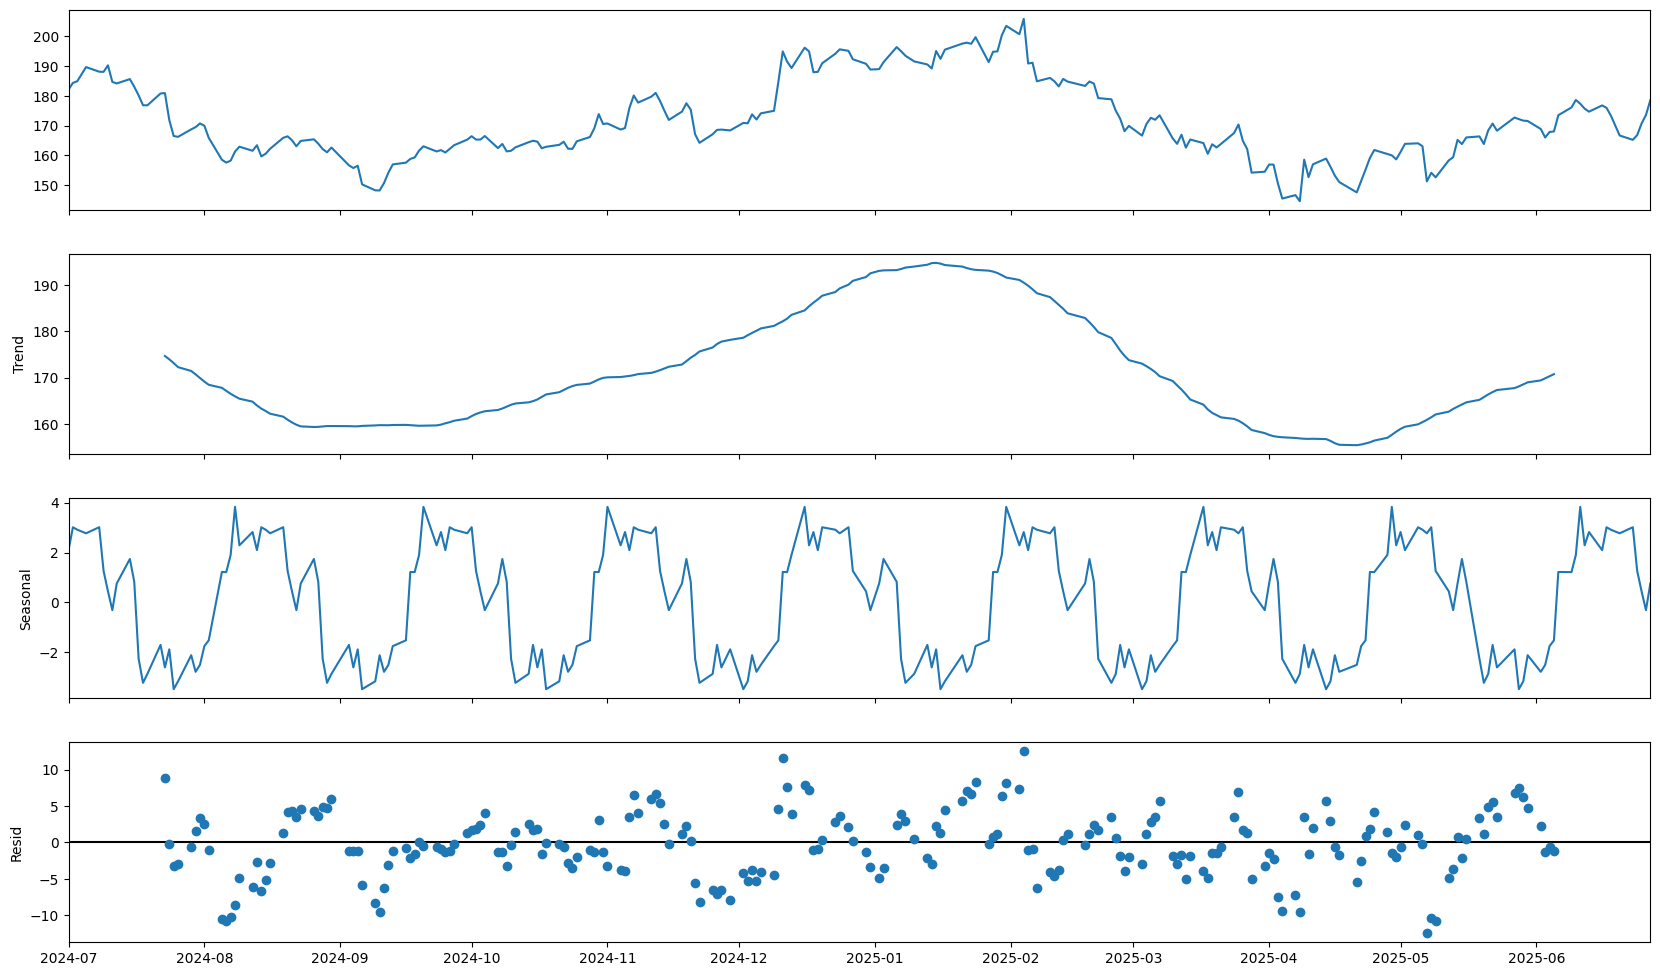

In [155]:
# Decompose the data to check for trend, seasonality, and noise components
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df, model='additive', period=30)
fig = result.plot()
fig.set_size_inches(18.5, 10.5)

Clearly depicts a smooth rise starting around October 2024, peaking around January 2025.

After that, the trend declines until mid-April and then starts increasing again.
This confirms a long-term cyclic pattern in the data.

Shows a clear repeating pattern of ups and downs.This supports the use of SARIMA over plain ARIMA, since seasonality is significant

Residuals fluctuate randomly around zero, indicating that much of the pattern in the original series has been captured by the trend and seasonality components.

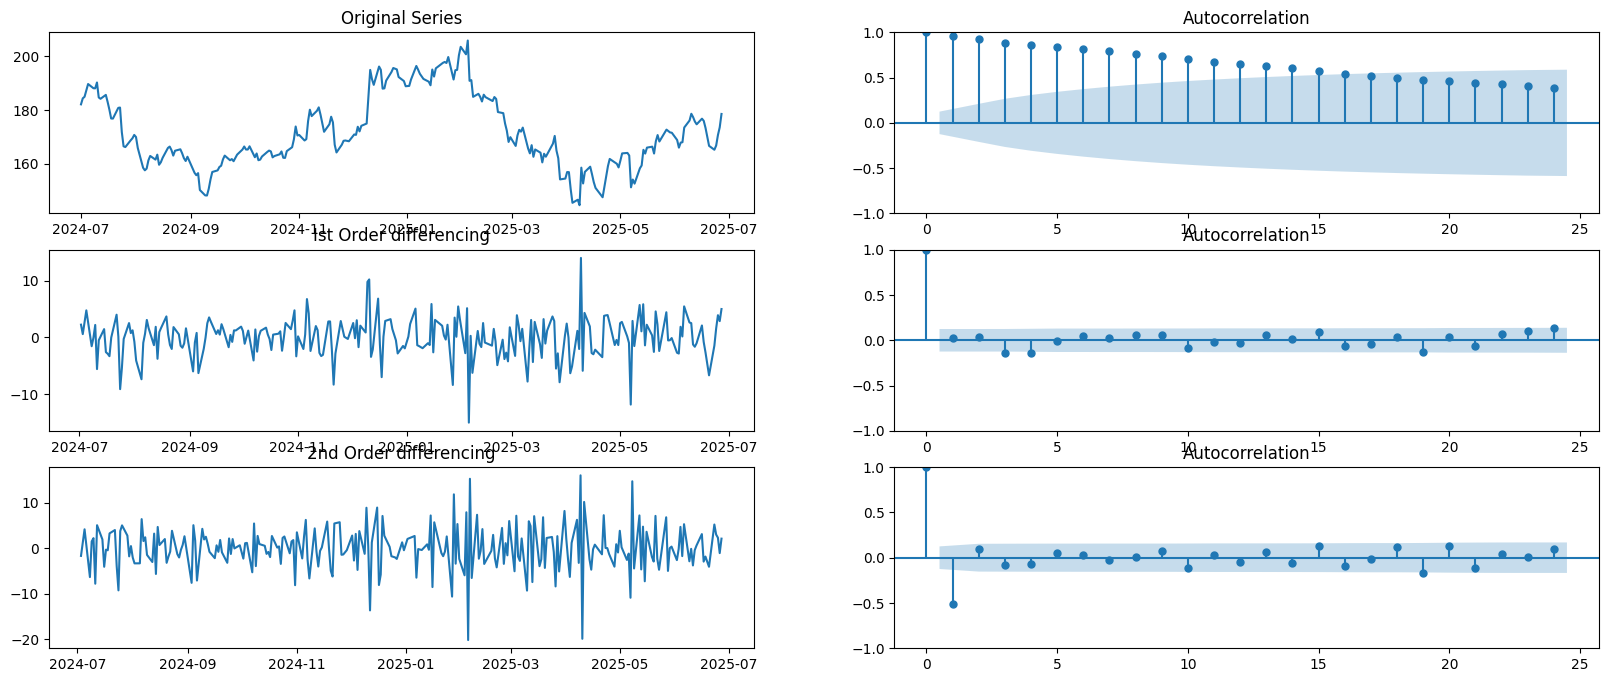

In [156]:
# Plotting ACF and PACF for original and differenced series to determine ARIMA orders
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig,axes = plt.subplots(3,2, figsize=(20,8))
axes[0,0].plot(df)
axes[0,0].set_title("Original Series")
plot_acf(df, ax=axes[0,1])

# Ist order differencing
axes[1,0].plot(df.diff())
axes[1,0].set_title("Ist Order differencing")
plot_acf(df.diff().dropna(),ax=axes[1,1])

# 2nd order differencing
axes[2,0].plot(df.diff().diff())
axes[2,0].set_title("2nd Order differencing")
plot_acf(df.diff().diff().dropna(),ax=axes[2,1])

plt.show()

In [157]:
# Checking stationarity after first order differencing to confirm the required differencing order
checking_stationarity(df.diff().dropna())

ADF Statistic: -9.589700
p-value: 0.000000
The series is stationary


In [158]:
# Setting the value for d (order of differencing) based on stationarity test
d = 1

In [159]:
#Calculating value of p

           0
0   1.000000
1   0.963706
2   0.926248
3   0.886711
4   0.856026
5   0.835808
6   0.815708
7   0.790997
8   0.765373
9   0.735781
10  0.702267
11  0.675402
12  0.650610
13  0.628204
14  0.602498
15  0.575405
16  0.543247
17  0.517843
18  0.496655
19  0.472950
20  0.457416
21  0.439475
22  0.425234
23  0.406512


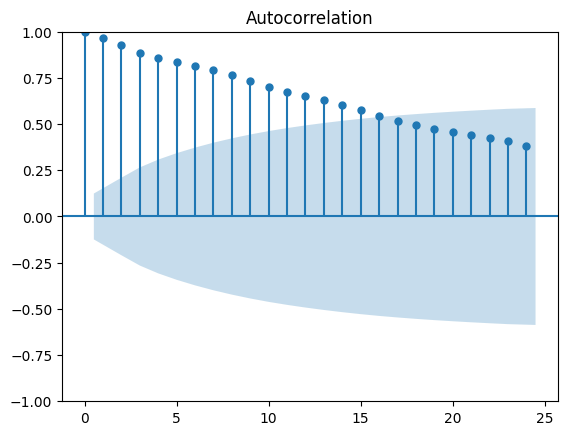

In [160]:
# Plotting PACF and printing values to determine p (order of the AR component)
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import acf , pacf
plot_acf(df, alpha=0.05)

x_acf = pd.DataFrame(acf(df))
print(x_acf)

In [161]:
# Setting the value for p based on PACF plot
p = 2

           0
0   1.000000
1   0.967592
2  -0.038980
3  -0.054411
4   0.119494
5   0.146996
6  -0.027264
7  -0.086313
8   0.015511
9  -0.050371
10 -0.108320
11  0.077588
12  0.015666
13 -0.022183
14 -0.078658
15  0.007962
16 -0.082800
17  0.074218
18  0.052392
19 -0.103213
20  0.118669
21  0.002291
22  0.052672
23 -0.094666


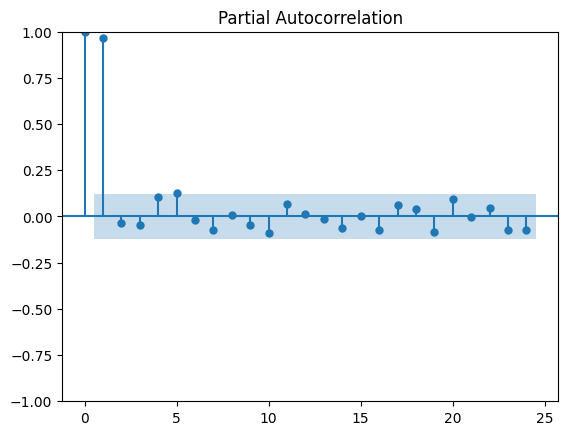

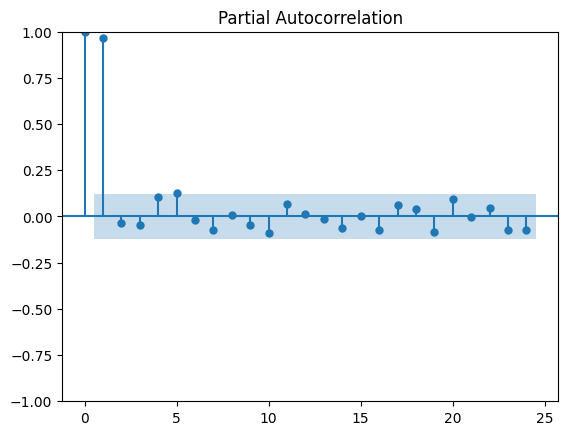

In [162]:
#Finding q
x_pacf = pd.DataFrame(pacf(df))
print(x_pacf)
plot_pacf(df, alpha=0.05)

In [163]:
# Setting the value for q based on ACF plot and summarizing p, d, q
# q = 2
p = 2
d = 1
q = 2

In [164]:
# Using Arima model with determined orders (p, d, q)
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df, order=(p,d,q))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  249
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -655.504
Date:                Mon, 30 Jun 2025   AIC                           1321.007
Time:                        08:04:35   BIC                           1338.574
Sample:                             0   HQIC                          1328.079
                                - 249                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3824      0.035     39.313      0.000       1.314       1.451
ar.L2         -0.9686      0.040    -24.130      0.000      -1.047      -0.890
ma.L1         -1.3815      0.047    -29.487      0.0

In [165]:
# Function to plot forecast alongside original data for visualization
def plot_forecast(model_fit, df, n_periods=30, column_name='Close'):
    """
    Plots model forecast alongside original time series data.

    Parameters:

    - df: DataFrame with datetime index and a 'Close' column
    - n_periods: Number of future periods to forecast (default = 30)
    - column_name: Name of the column to forecast (default = 'Close')
    """

    # Generate forecast
    forecast_result = model_fit.get_forecast(n_periods)
    forecast_mean = forecast_result.predicted_mean

    # Future date index
    last_date = df.index[-1]
    forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_periods, freq='D')

    # Forecast series with proper index
    forecast_series = pd.Series(forecast_mean.values, index=forecast_index)

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(df[column_name], label='Original')
    plt.plot(forecast_series, label='Forecast', color='orange')
    plt.axvline(x=last_date, color='gray', linestyle='--', label='Forecast Start')
    plt.legend()
    plt.title(f"{column_name} Forecast with ARIMA")
    plt.show()

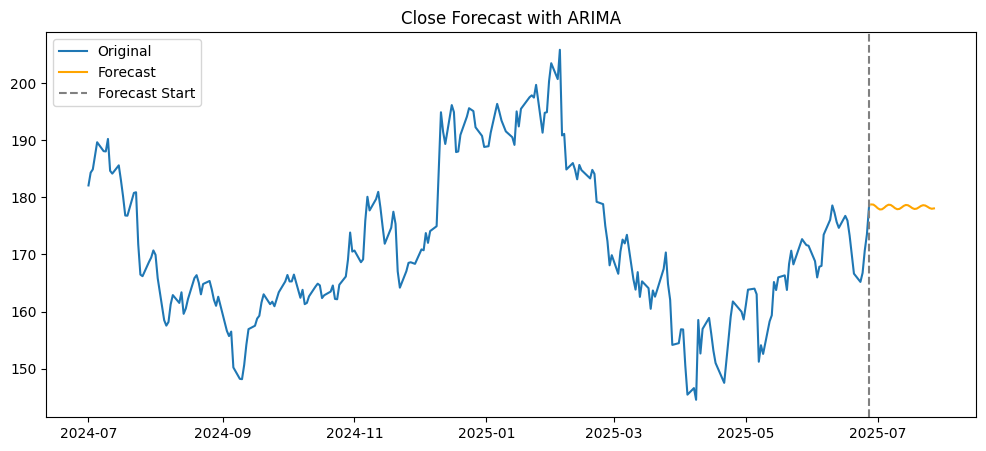

In [166]:
# Plotting forecast for the next 30 days using the trained ARIMA model
plot_forecast(model_fit,df)

The ARIMA model performs poorly due to the presence of seasonality in the data. To address this, we'll use the SARIMA model , an extension of ARIMA that is specifically designed to handle seasonal patterns.

In [167]:
# Use Sarima Model, including seasonal orders (P, D, Q, m)
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(df, order=(p,d,q), seasonal_order=(p,d,q,12))
model_fit = model.fit()

In [168]:
# Printing the summary of the SARIMA model to evaluate its performance
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  249
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood                -639.002
Date:                            Mon, 30 Jun 2025   AIC                           1296.005
Time:                                    08:04:44   BIC                           1327.179
Sample:                                         0   HQIC                          1308.571
                                            - 249                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5252      0.181     -2.906      0.004      -0.879      -0.171
ar.L2         -0.6978      0.199   

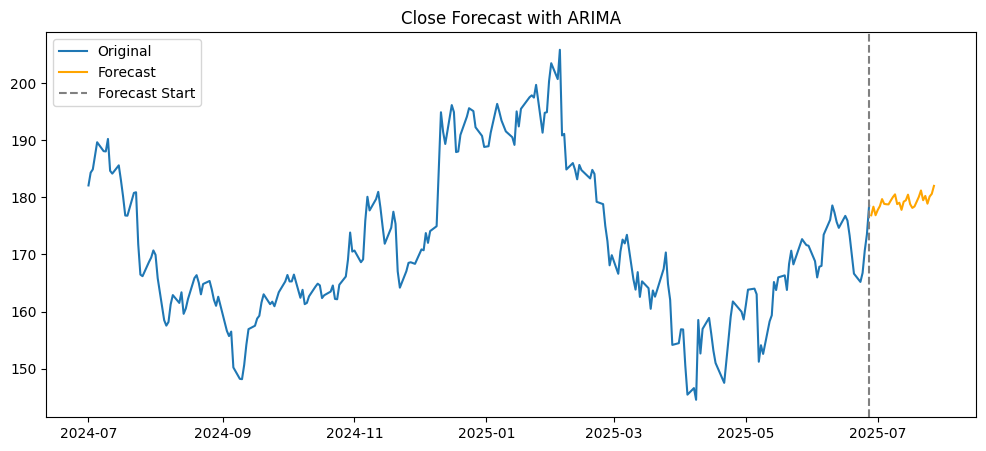

In [169]:
# Plotting forecast for 30 days using the trained SARIMA model
plot_forecast(model_fit,df)

Next, we’ll use Auto ARIMA , an automated approach that identifies the most suitable ARIMA model by evaluating and selecting the optimal values for the parameters p (autoregressive term), d (differencing), and q (moving average term) based on our data

In [170]:
!pip install pmdarima

In [171]:
import pmdarima as pm

In [172]:
model = pm.auto_arima(df,
                      start_p=1,
                      start_q=1,
                      max_p=3,
                      max_q=3,
                      seasonal=True,
                      m=12,
                      d=1,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      )

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=1328.720, Time=1.78 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1323.326, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1327.040, Time=0.38 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1327.086, Time=2.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1321.330, Time=0.14 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1325.158, Time=0.65 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1325.195, Time=0.41 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1324.826, Time=1.24 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1325.218, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1325.226, Time=0.40 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1327.198, Time=1.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 8.432 seconds


Splitting data into train and test to check its Accuracy [MAE AND RMSE]

In [173]:
#Splitting the data
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

#First Using Arima model  

In [174]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train, order=(p, d, q))
model_fit = model.fit()


In [175]:
# Forecast the same number of steps as test length
y_pred = model_fit.forecast(steps=len(test))

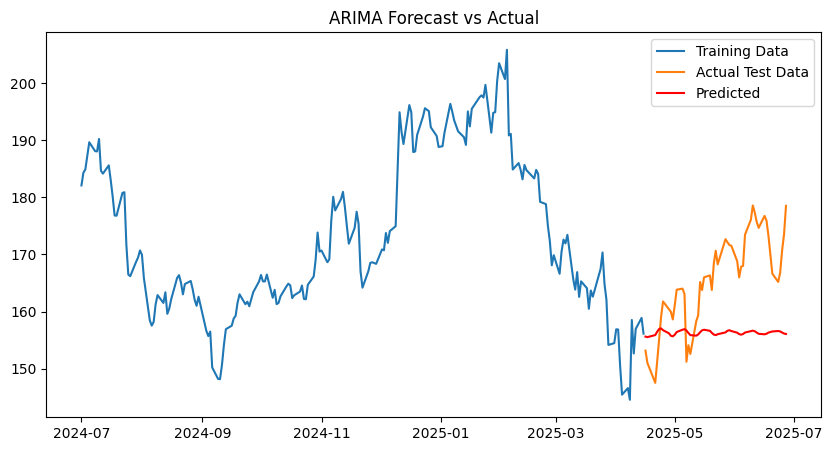

MAE: 10.63
RMSE: 12.28


In [176]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Plot
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Test Data')
plt.plot(test.index, y_pred, label='Predicted', color='red')
plt.legend()
plt.title('ARIMA Forecast vs Actual')
plt.show()

# Accuracy Metrics
mse = mean_squared_error(test, y_pred)
mae = mean_absolute_error(test, y_pred)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


#Now Using Sarima model

In [179]:
# Use Sarima Model, including seasonal orders (P, D, Q, m)
p, d, q = 0, 1, 0
P, D, Q, m = 1, 0, 1, 12
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train, order=(p,d,q), seasonal_order=(p,d,q,12))
model_fit = model.fit()

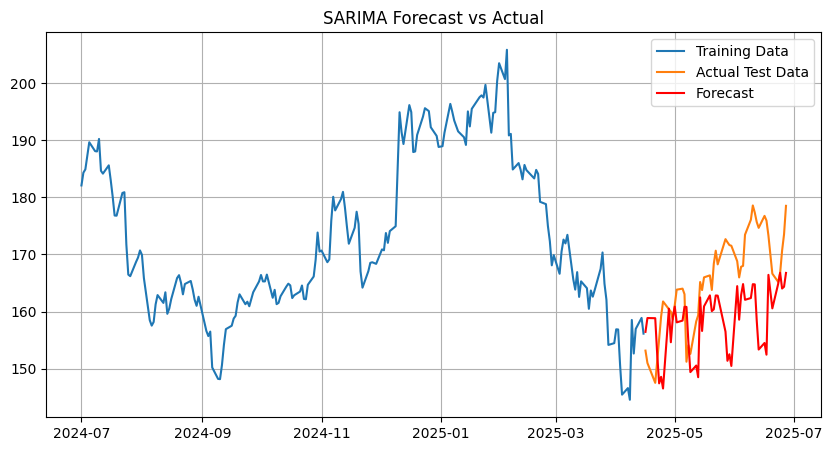

MAE: 8.52
RMSE: 10.67


In [180]:
y_pred = model_fit.forecast(steps=len(test))
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Plot
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Test Data')
plt.plot(test.index, y_pred, label='Forecast', color='red')
plt.legend()
plt.title('SARIMA Forecast vs Actual')
plt.grid(True)
plt.show()

# Accuracy Metrics
mae = mean_absolute_error(test, y_pred)
rmse = np.sqrt(mean_squared_error(test, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")